In [23]:
import os
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
from ResoFit.calibration import Calibration
from ResoFit.fitresonance import FitResonance
from ResoFit.experiment import Experiment
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as ss
import pprint
from ResoFit._utilities import get_foil_density_gcm3
from ResoFit._utilities import Layer
import peakutils as pku

In [2]:
%matplotlib notebook

In [3]:
# Global parameters
energy_min = 14
energy_max = 300
energy_step = 0.01
# Input sample name or names as str, case sensitive
layer_1 = 'Ag'
thickness_1 = 0.05  # mm
density_1 = None
# density = get_foil_density_gcm3(length_mm=25, width_mm=25, thickness_mm=0.025, mass_g=0.14)
# layer_2 = 'Gd'
# thickness_2 = 0.015
# density_2 = None
# layer_3 = 'Cd'
# thickness_3 = 0.015
# density_3 = None
layer = Layer()
layer.add_layer(layer=layer_1, thickness_mm=thickness_1, density_gcm3=density_1)

In [5]:
foil_list = ['Ag', 'Co', 'Hf', 'W', 'In', 'Cd', 'Au']
data_file_list = [x + '.csv' for x in foil_list]
folder = 'data/IPTS_13639/reso_data_13639'
spectra_file = 'spectra.csv'
exps = {}
for each_data in data_file_list:
    _ele_name = each_data.split('.')[0]
    exps[_ele_name] = Experiment(spectra_file=spectra_file, data_file=each_data, folder=folder)
    exps[_ele_name].slice(start=294, end=2720)

In [6]:
exps

{'Ag': <ResoFit.experiment.Experiment at 0x11cd3aa90>,
 'Co': <ResoFit.experiment.Experiment at 0x10b1a1dd8>,
 'Hf': <ResoFit.experiment.Experiment at 0x11cf51da0>,
 'W': <ResoFit.experiment.Experiment at 0x11cf56e10>,
 'In': <ResoFit.experiment.Experiment at 0x11cf52ef0>,
 'Cd': <ResoFit.experiment.Experiment at 0x11cf59128>,
 'Au': <ResoFit.experiment.Experiment at 0x11cf5cda0>}

In [7]:
image_start = 500  # Can be omitted or =None
image_end = 1600  # Can be omitted or =None
# norm_to_file = 'ob_1.csv'  #'Ag.csv'
# norm_to_file = 'Ag.csv'
norm_to_file = None

repeat = 1
source_to_detector_m = 16.123278721983177  # 16#16.445359069030175#16.447496101100739
offset_us = -12112.494119089204  # 0#2.7120797253959119#2.7355447625559037

<IPython.core.display.Javascript object>


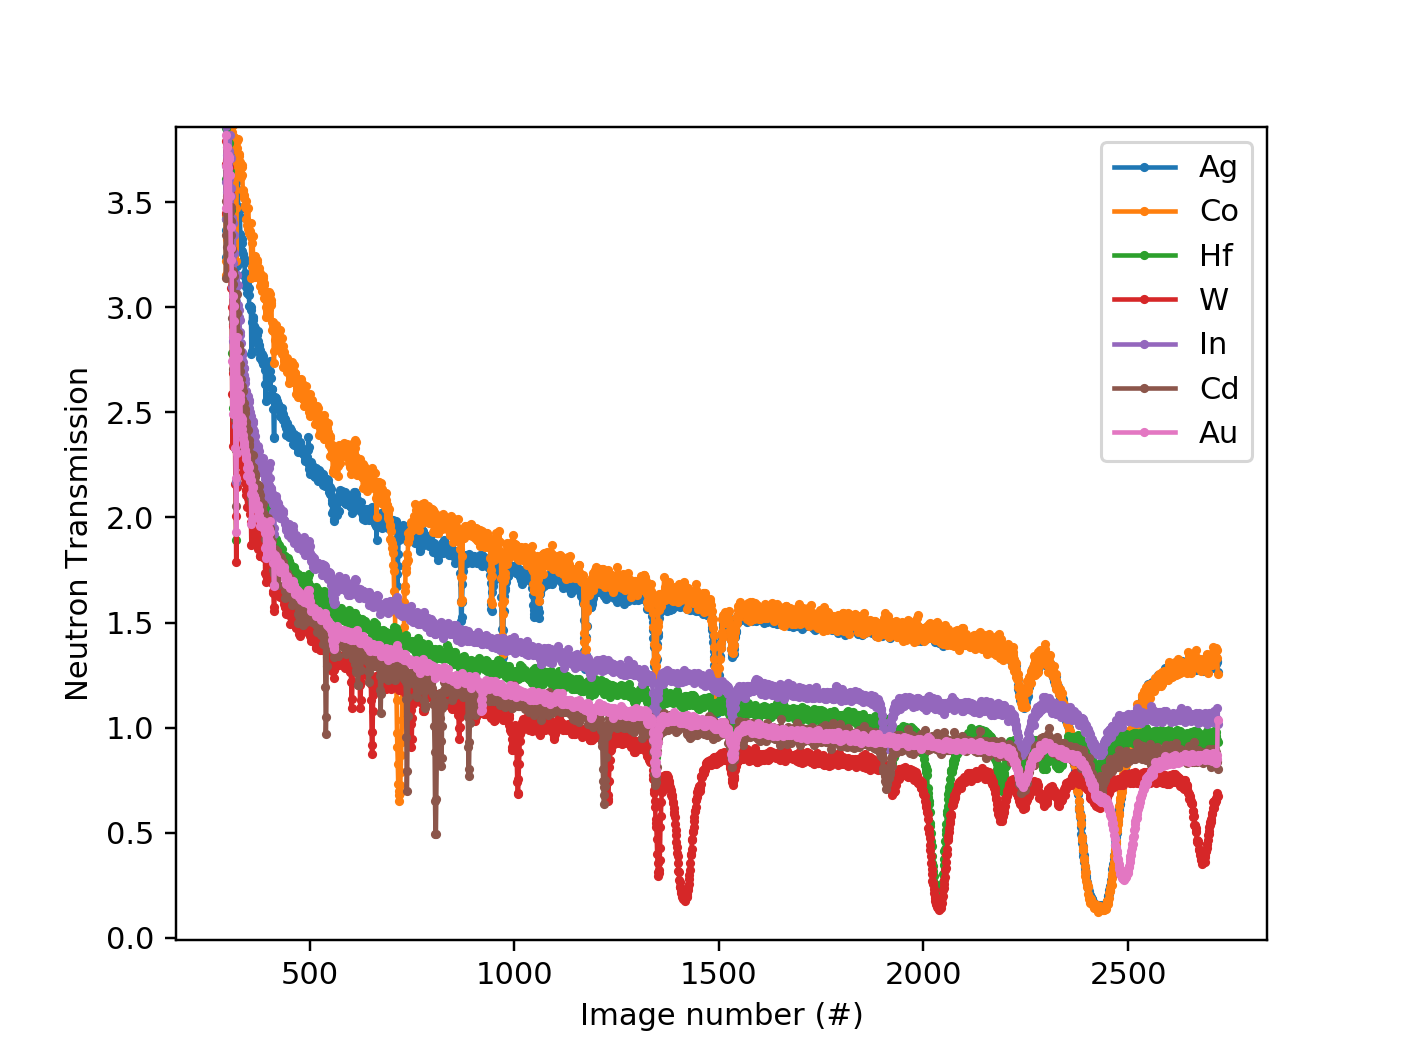

In [8]:
fg0, ax0 = plt.subplots()
for _ele in foil_list:
    ax0 = exps[_ele].plot_raw(ax_mpl=ax0, x_type='number', y_type='transmission', source_to_detector_m=source_to_detector_m, offset_us=offset_us)

<IPython.core.display.Javascript object>


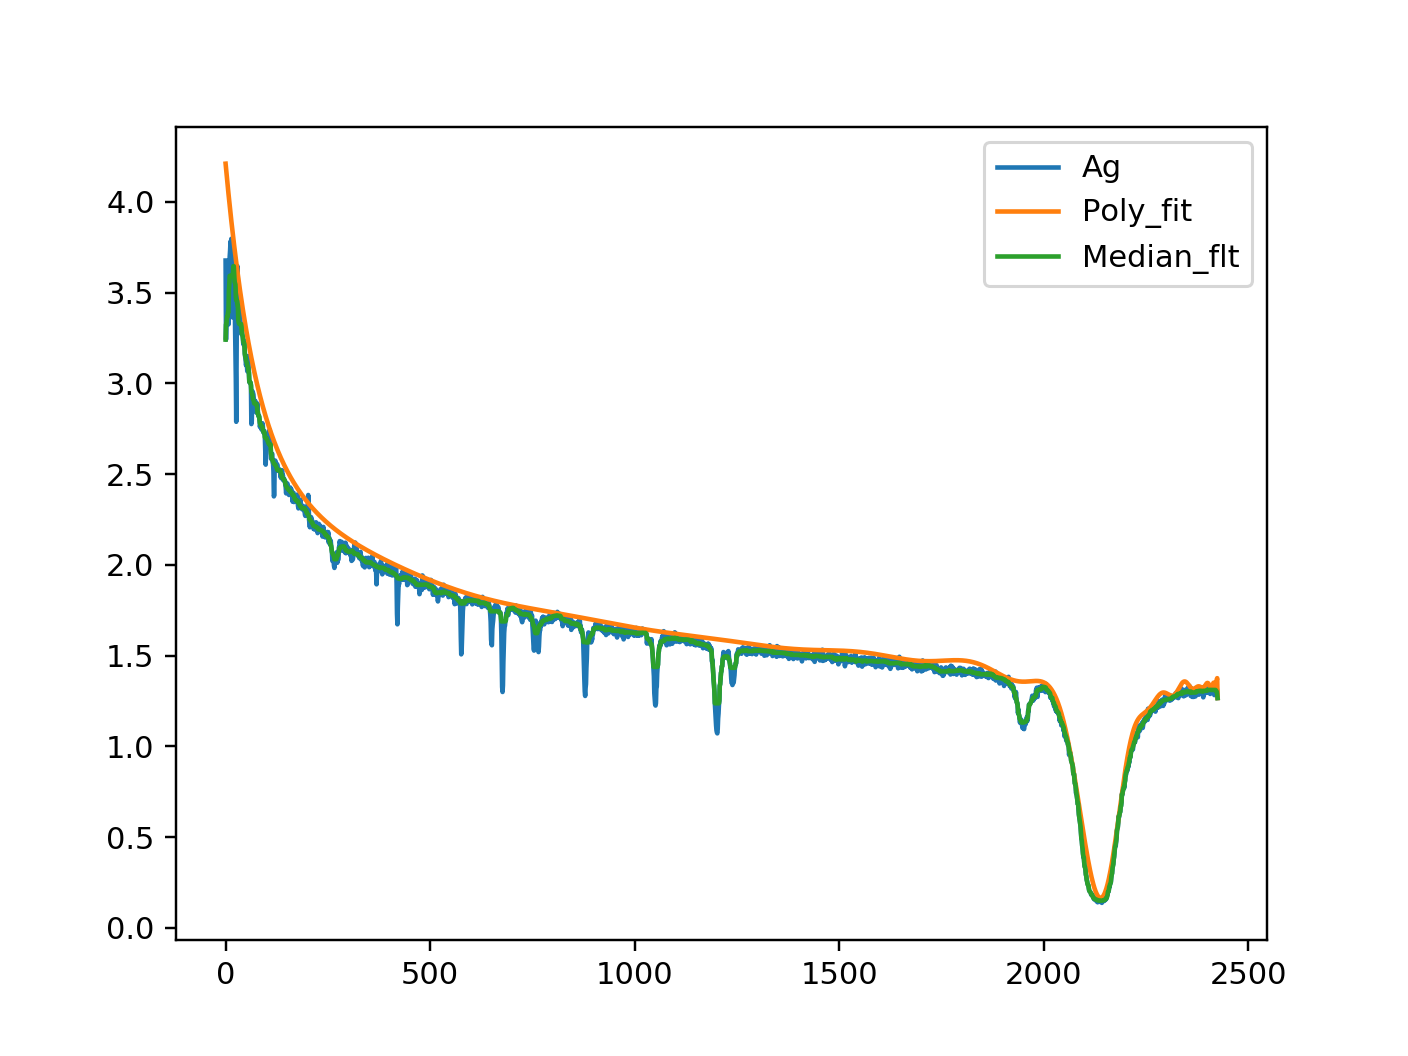

In [41]:
arr_ag = np.array(exps['Ag'].data[0])
bkg_ag = pku.envelope(y=arr_ag, deg=500, max_it=None, tol=None)
flt_ag = ss.medfilt(arr_ag, 21)
fig1, ax1 = plt.subplots()
ax1.plot(arr_ag, label='Ag')
ax1.plot(bkg_ag, label='Poly_fit')
ax1.plot(flt_ag, label='Median_flt')
ax1.legend()

<IPython.core.display.Javascript object>


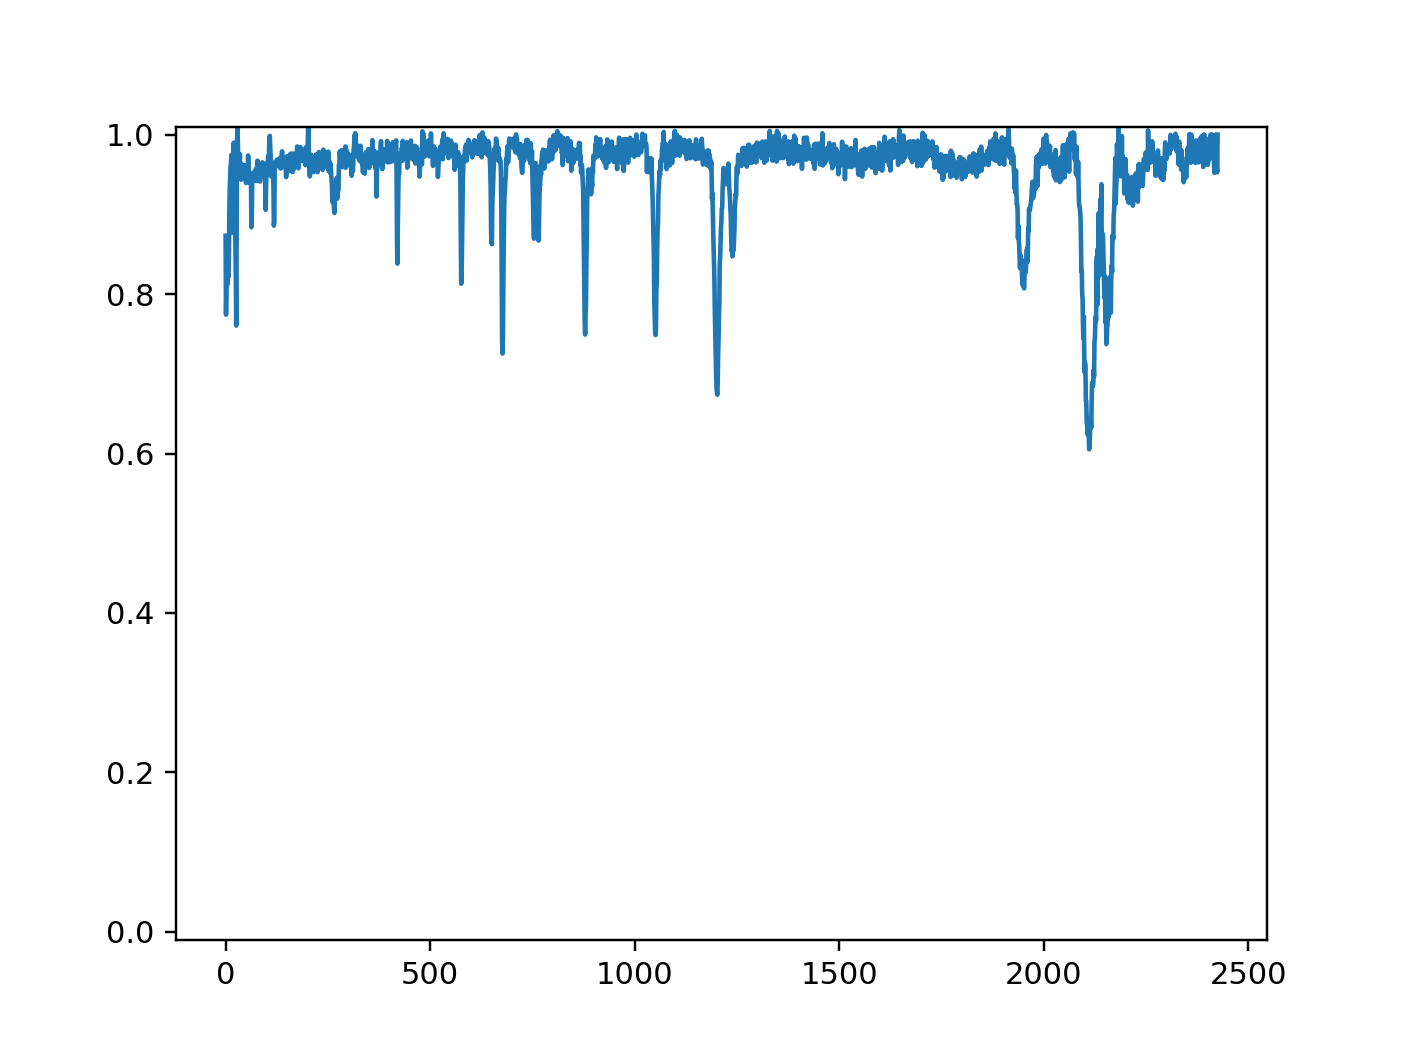

(-0.01, 1.01)

In [43]:
fig2, ax2 = plt.subplots()
ax2.plot(arr_ag/bkg_ag)
ax2.set_ylim(top=1.01, bottom=-0.01)

+----------------- Calibration -----------------+
Params before:
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us             -1.211e+04     -inf      inf     None     True     None     None
source_to_detector_m     16.12     -inf      inf     None     True     None     None

Params after:
Name                     Value      Min      Max   Stderr     Vary     Expr Brute_Step
offset_us             -1.211e+04     -inf      inf  0.02492     True     None     None
source_to_detector_m     15.68     -inf      inf 0.003356     True     None     None
Calibration chi^2 : 1048.9439412099769



<IPython.core.display.Javascript object>


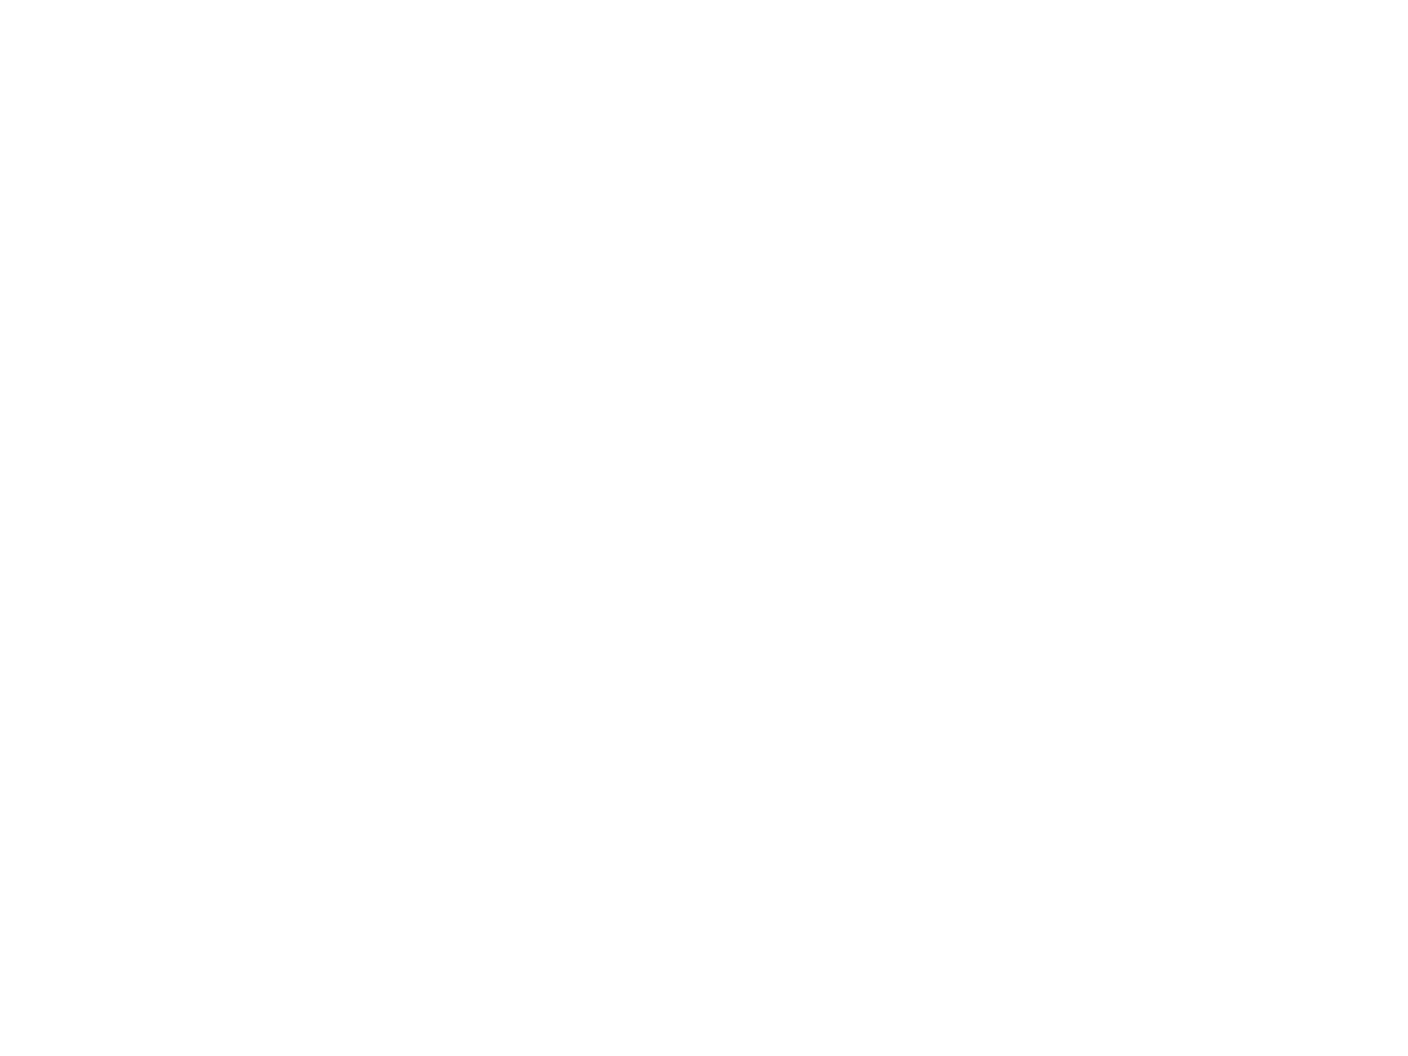

+----------------- Fitting (thickness) -----------------+
Params before:
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
density_gcm3_Ag      10.5        0      inf     None    False     None     None
thickness_mm_Ag      0.05        0      inf     None     True     None     None

Params after:
Name                Value      Min      Max   Stderr     Vary     Expr Brute_Step
density_gcm3_Ag      10.5        0      inf        0    False     None     None
thickness_mm_Ag     0.119        0      inf 0.002931     True     None     None
Fitting chi^2 : 1029.7154136003012

Molar-conc. (mol/cm3)	Before_fit	After_fit
Ag	0.09734101431191028	0.09734101431191028




<IPython.core.display.Javascript object>


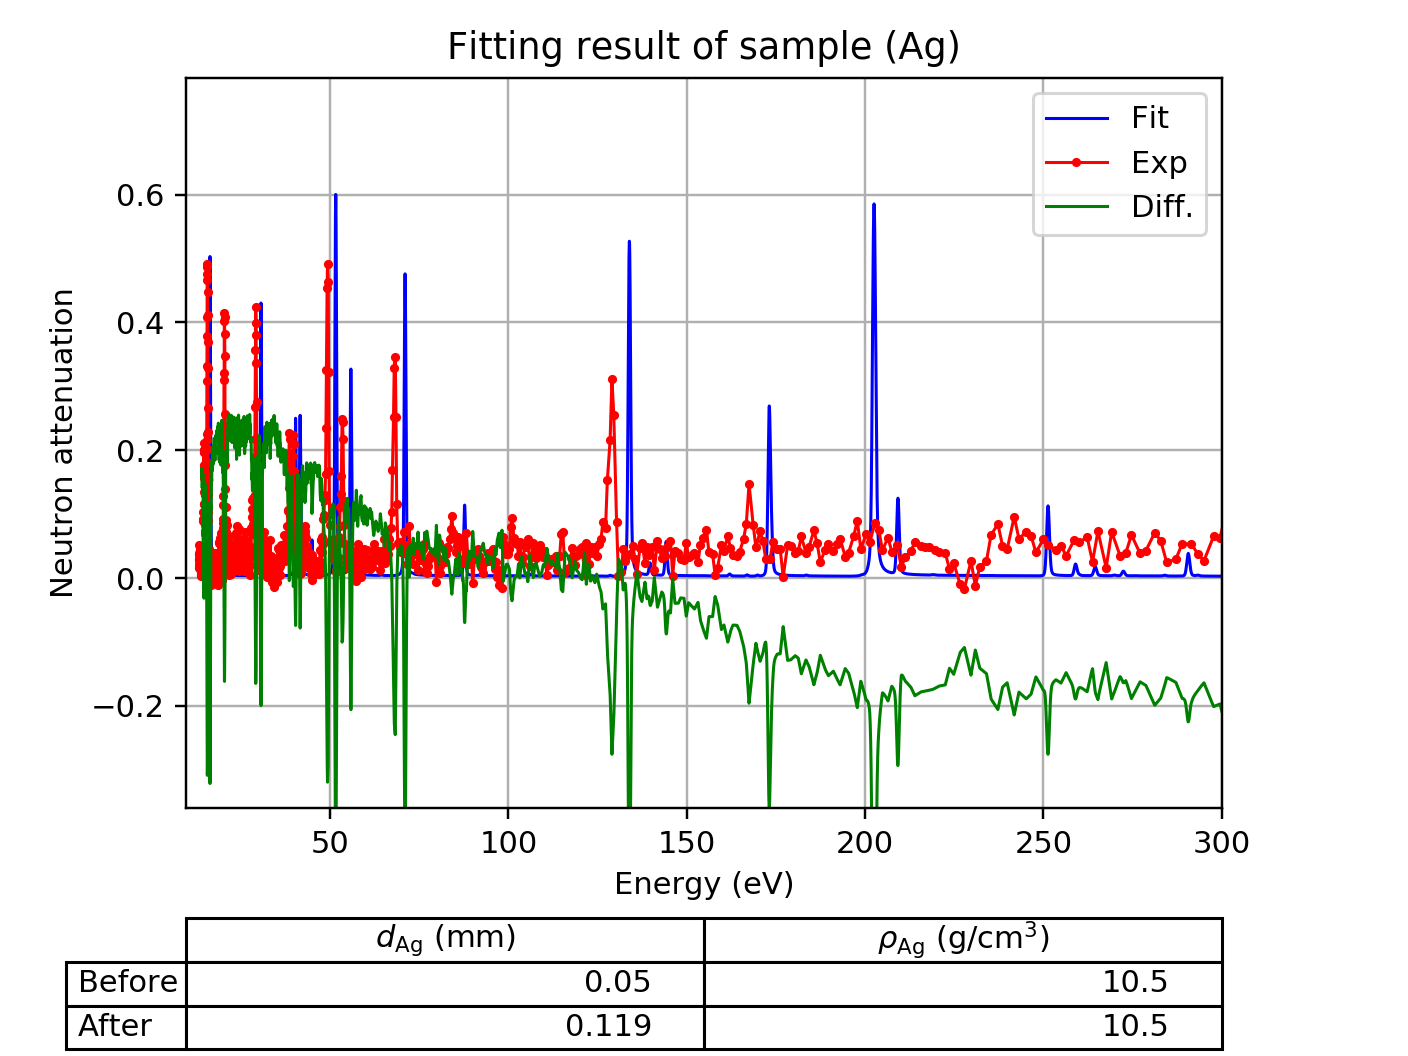

In [7]:
# Calibrate the peak positions
calibration = Calibration(data_file=data_file,
                          spectra_file=spectra_file,
                          layer=layer,
                          energy_min=energy_min,
                          energy_max=energy_max,
                          energy_step=energy_step,
                          repeat=repeat,
                          folder=folder,
                          baseline=baseline)

calibration.norm_to(norm_to_file)
calibration.slice(slice_start=image_start, slice_end=image_end)

calibrate_result = calibration.calibrate(source_to_detector_m=source_to_detector_m,
                                         offset_us=offset_us,
                                         vary='all',
                                         each_step=each_step)
calibration.plot(before=before)


# Fit the peak height
fit = FitResonance(folder=folder,
                   spectra_file=spectra_file,
                   data_file=data_file,
                   repeat=repeat,
                   energy_min=energy_min,
                   energy_max=energy_max,
                   energy_step=energy_step,
                   calibrated_offset_us=calibration.calibrated_offset_us,
                   calibrated_source_to_detector_m=calibration.calibrated_source_to_detector_m,
                   norm_to_file=norm_to_file,
                   slice_start=image_start,
                   slice_end=image_end,
                   baseline=baseline)
fit_result = fit.fit(layer, vary='thickness', each_step=each_step)
fit.molar_conc()
fit.plot()